In [1]:
##############################################################################################################
# DESCRIPTION: 
#              
# RESULTS:     
#              
##############################################################################################################

In [2]:
######################
# CONFIG & HYPERPARAMS
######################

import os

class HyperParams:
    pass

IMG_PATH = "C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/"

hyperparams = HyperParams()
hyperparams.IMG_WIDTH = 64
hyperparams.IMG_HEIGHT = 64
hyperparams.EPOCHS = 300 # 600 #10000
hyperparams.BATCH_SIZE = 16
hyperparams.START_NEURONS = 8 # UNET
hyperparams.LOSS = 'mean_absolute_error'

IMG_WIDTH = hyperparams.IMG_WIDTH
IMG_HEIGHT = hyperparams.IMG_HEIGHT

IMG_CASE = str(IMG_WIDTH) +  "/0001_0010"
MODEL_NAME = "0001_0010-64-unet-xxn3"

IMG_PATH_VALID = IMG_PATH + "validation/"
IMG_PATH_TEST = IMG_PATH + "test/"
IMG_PATH_TRAIN = IMG_PATH

DEST_TESTS = os.path.abspath(os.path.join('../../../out_tests/', MODEL_NAME))

class RadianceLimits:
    pass
radiance_limits = RadianceLimits()
radiance_limits.noisy_min = 0
radiance_limits.noisy_max = 0.1418
radiance_limits.nitid_min = 0
radiance_limits.nitid_max = 0.2947

#from tensorflow.keras.optimizers import Adam
#hyperparams.OPTIMIZER = Adam(learning_rate=0.0001)
from tensorflow.keras.optimizers import Nadam
hyperparams.OPTIMIZER = Nadam(learning_rate=0.0001)
#from tensorflow.keras.optimizers import RMSprop
#hyperparams.OPTIMIZER = RMSprop(learning_rate = 0.0001)

In [3]:
##################
# IMPORTS
##################

import tensorflow as tf
from tensorflow.compat.v1 import InteractiveSession

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import numpy as np
import tensorflow 
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)
import os, sys
module_path = os.path.abspath(os.path.join('../../support/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import DatasetUtilsTifF as dsutils
import TrainModelD as train
import ReportsK as reports
import UnetI as model_factory

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print(f"Tensorflow version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

tf.config.list_physical_devices('GPU')

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1707439791328804178
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5722079232
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15819136505282088709
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6"
]
Tensorflow version: 2.6.0
Keras Version: 2.6.0
GPU is available


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
##################
# MODEL DEFINITION
##################

model = model_factory.buildModel(hyperparams)
model.summary()
model.optimizer.get_config()

Loss=mean_absolute_error
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 8)    584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 8)    0           conv2d_1[0][0]                   
_____________________________________________________________________

{'name': 'Nadam',
 'learning_rate': 0.0001,
 'decay': 0.004,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07}

In [6]:
##################
# PREPARE DATA
##################

train_noisy_files, train_nitid_files, train_noisy, train_nitid = dsutils.readDataset( IMG_PATH_TRAIN, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)
val_noisy_files, val_nitid_files, val_noisy, val_nitid = dsutils.readDataset( IMG_PATH_VALID, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)

train_noisy, train_nitid = dsutils.reshapeDataset( train_noisy, train_nitid, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )
val_noisy, val_nitid = dsutils.reshapeDataset( val_noisy, val_nitid, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )

Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/
Noisy files:19657
Nitid files:19657
Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/validation/
Noisy files:4900
Nitid files:4900


In [7]:
##################
# TRAIN MODEL
##################
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

checkpoint_filepath = os.path.abspath(os.path.join('../../../saves/') + MODEL_NAME \
                                      + "_checkpoint_" + '_weights_{epoch:02d}-{val_loss:.2f}')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

hist = train.fit( model, hyperparams, train_noisy, train_nitid, val_noisy, val_nitid, patience = 50, \
                 callbacks=[model_checkpoint_callback] )

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6

Epoch 1/300
1229/1229 [==============================] - 51s 36ms/step - loss: 0.1319 - val_loss: 0.1330
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0010-64-unet-xxn3_checkpoint__weights_01-0.13\assets
Epoch 2/300
1229/1229 [==============================] - 44s 36ms/step - loss: 0.0607 - val_loss: 0.0485
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0010-64-unet-xxn3_checkpoint__weights_02-0.05\assets
Epoch 3/300
1229/1229 [==============================] - 44s 36ms/step - loss: 0.0450 - val_loss: 0.0455
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0010-64-unet-xxn3_checkpoint__weights_03-0.05\assets
Epoch 4/300
1229/1229 [==============================] - 44s 35ms/step - loss: 0.0434 - val_loss: 0.0452
INFO:tensorflow:Assets written to: C:\Projects\V

1229/1229 [==============================] - 43s 35ms/step - loss: 0.0228 - val_loss: 0.0315
Epoch 66/300
1229/1229 [==============================] - 43s 35ms/step - loss: 0.0230 - val_loss: 0.0328
Epoch 67/300
1229/1229 [==============================] - 43s 35ms/step - loss: 0.0226 - val_loss: 0.0305
Epoch 68/300
1229/1229 [==============================] - 43s 35ms/step - loss: 0.0227 - val_loss: 0.0315
Epoch 69/300
1229/1229 [==============================] - 43s 35ms/step - loss: 0.0226 - val_loss: 0.0306
Epoch 70/300
1229/1229 [==============================] - 43s 35ms/step - loss: 0.0227 - val_loss: 0.0326
Epoch 71/300
1229/1229 [==============================] - 42s 35ms/step - loss: 0.0225 - val_loss: 0.0306
Epoch 72/300
1229/1229 [==============================] - 42s 34ms/step - loss: 0.0225 - val_loss: 0.0313
Epoch 73/300
1229/1229 [==============================] - 43s 35ms/step - loss: 0.0224 - val_loss: 0.0298
Epoch 74/300
1229/1229 [==============================] - 4

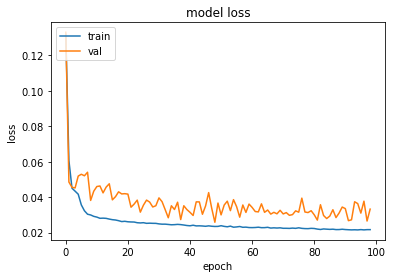

Best Epoch:49


In [8]:
##################
# REPORTS
##################

reports.plotHistory( hist )

In [9]:
model.save(os.path.abspath(os.path.join('../../../saves/', MODEL_NAME)), model)

INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0010-64-unet-xxn3\assets


In [10]:
##################
# PREDICTIONS
##################
ACCURACY_THRESHOLD = 0.01
predictions_metrics, predictions_headers \
    = reports.calcPredictionMetrics( model, val_noisy, val_nitid, ACCURACY_THRESHOLD, \
                                    save_pred = True, save_path = DEST_TESTS, \
                                    noisy_files = val_noisy_files, nitid_files = val_nitid_files, \
                                    max_nitid= radiance_limits.nitid_max  )

Black image found
Black image found
Images count =4900
Best RMSENZ  =4698 (0.96)
Best MAENZ   =4687 (0.96)
Best PSNR    =4698 (0.96)
Best Accuracy=4594 (0.94)
RMSE-NZ  Pred=0.0328  Noisy=0.1031
MAE-NZ   Pred=0.0258  Noisy=0.0937
PSNR     Pred=17.5 dB Noisy=8.8 dB
Accuracy Pred=0.36    Noisy=0.12
SSM      Pred=0.79    Noisy=0.43
HOG MSE  Pred=0.09    Noisy=0.08


In [11]:
reports.saveMetrics( DEST_TESTS, MODEL_NAME, predictions_headers, predictions_metrics )

Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test/
Noisy files:17
Nitid files:17
Index:0
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0025_06_00_2_noisy_idx006.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0025_06_00_2_nitid_idx008.tif


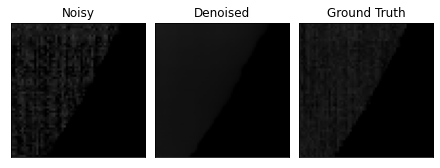

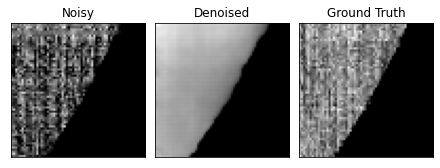

RMSE-NZ  Pred=0.0194  Noisy=0.0423 BEST
MAE-NZ   Pred=0.0120  Noisy=0.0298 BEST
PSNR     Pred=17.9 dB Noisy=11.1 dB BEST
Accuracy Pred=0.59    Noisy=0.36 BEST
SSM      Pred=0.81    Noisy=0.66
HOG MSE  Pred=0.08    Noisy=0.01
******************************************************
Index:1
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0025_06_01_5_noisy_idx020.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0025_06_01_5_nitid_idx017.tif


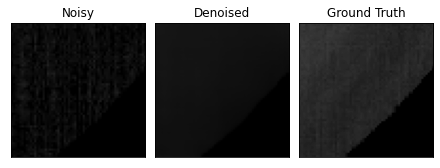

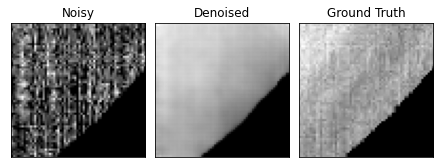

RMSE-NZ  Pred=0.0823  Noisy=0.1180 BEST
MAE-NZ   Pred=0.0717  Noisy=0.1096 BEST
PSNR     Pred=9.2 dB Noisy=6.1 dB BEST
Accuracy Pred=0.20    Noisy=0.07 BEST
SSM      Pred=0.65    Noisy=0.61
HOG MSE  Pred=0.05    Noisy=0.09
******************************************************
Index:2
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0330_02_04_9_noisy_idx157.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0330_02_04_9_nitid_idx146.tif


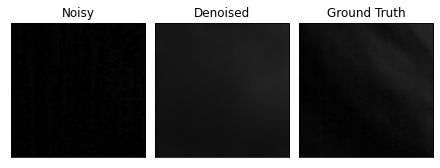

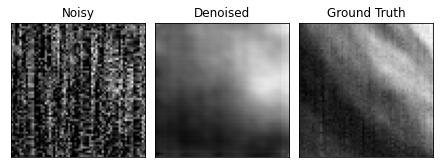

RMSE-NZ  Pred=0.0403  Noisy=0.0587 BEST
MAE-NZ   Pred=0.0363  Noisy=0.0477 BEST
PSNR     Pred=11.9 dB Noisy=8.6 dB BEST
Accuracy Pred=0.09    Noisy=0.13 WORST
SSM      Pred=0.74    Noisy=0.19
HOG MSE  Pred=0.09    Noisy=0.07
******************************************************
Index:3
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0330_03_03_11_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0330_03_03_11_nitid_idx134.tif


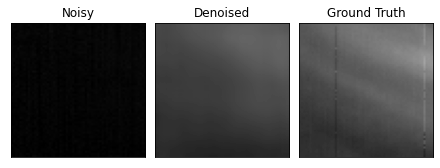

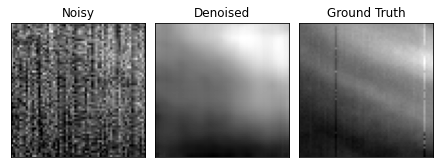

RMSE-NZ  Pred=0.0915  Noisy=0.3357 BEST
MAE-NZ   Pred=0.0818  Noisy=0.3214 BEST
PSNR     Pred=16.9 dB Noisy=5.6 dB BEST
Accuracy Pred=0.04    Noisy=0.00 BEST
SSM      Pred=0.84    Noisy=0.13
HOG MSE  Pred=0.14    Noisy=0.11
******************************************************
Index:4
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0330_03_03_13_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0330_03_03_13_nitid_idx134.tif


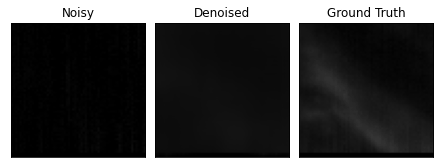

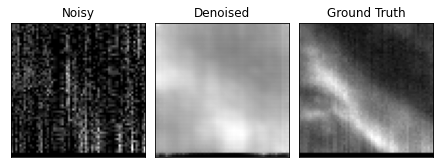

RMSE-NZ  Pred=0.0465  Noisy=0.0869 BEST
MAE-NZ   Pred=0.0352  Noisy=0.0747 BEST
PSNR     Pred=13.1 dB Noisy=7.7 dB BEST
Accuracy Pred=0.20    Noisy=0.01 BEST
SSM      Pred=0.78    Noisy=0.26
HOG MSE  Pred=0.06    Noisy=0.11
******************************************************
Index:5
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0330_03_03_3_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0330_03_03_3_nitid_idx134.tif


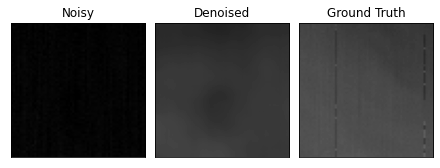

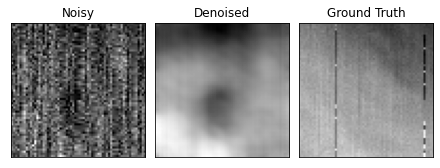

RMSE-NZ  Pred=0.0753  Noisy=0.2662 BEST
MAE-NZ   Pred=0.0719  Noisy=0.2643 BEST
PSNR     Pred=14.0 dB Noisy=3.1 dB BEST
Accuracy Pred=0.00    Noisy=0.00 BEST
SSM      Pred=0.83    Noisy=0.14
HOG MSE  Pred=0.11    Noisy=0.10
******************************************************
Index:6
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0330_03_03_5_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0330_03_03_5_nitid_idx134.tif


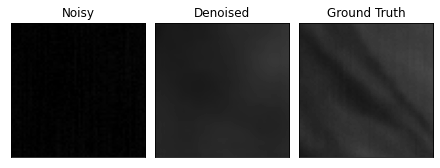

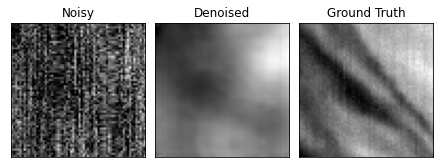

RMSE-NZ  Pred=0.0443  Noisy=0.1729 BEST
MAE-NZ   Pred=0.0387  Noisy=0.1686 BEST
PSNR     Pred=16.2 dB Noisy=4.4 dB BEST
Accuracy Pred=0.12    Noisy=0.00 BEST
SSM      Pred=0.85    Noisy=0.16
HOG MSE  Pred=0.10    Noisy=0.15
******************************************************
Index:7
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0338_04_00_10_noisy_idx006.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0338_04_00_10_nitid_idx008.tif


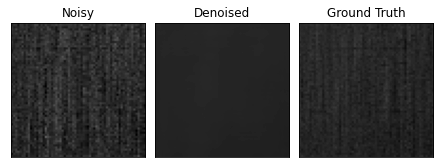

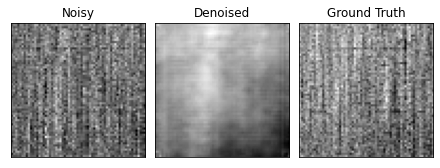

RMSE-NZ  Pred=0.0276  Noisy=0.0606 BEST
MAE-NZ   Pred=0.0221  Noisy=0.0478 BEST
PSNR     Pred=18.9 dB Noisy=12.0 dB BEST
Accuracy Pred=0.28    Noisy=0.15 BEST
SSM      Pred=0.61    Noisy=0.32
HOG MSE  Pred=0.04    Noisy=0.03
******************************************************
Index:8
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0339_04_03_5_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0339_04_03_5_nitid_idx134.tif


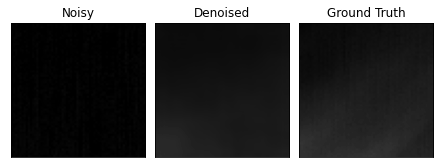

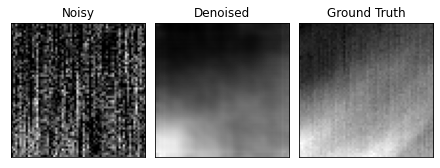

RMSE-NZ  Pred=0.0294  Noisy=0.1061 BEST
MAE-NZ   Pred=0.0248  Noisy=0.0983 BEST
PSNR     Pred=16.9 dB Noisy=5.8 dB BEST
Accuracy Pred=0.20    Noisy=0.00 BEST
SSM      Pred=0.92    Noisy=0.21
HOG MSE  Pred=0.18    Noisy=0.04
******************************************************
Index:9
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0339_05_03_8_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0339_05_03_8_nitid_idx134.tif


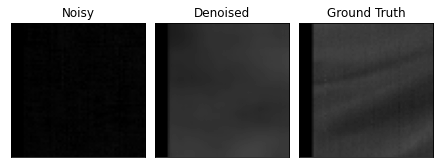

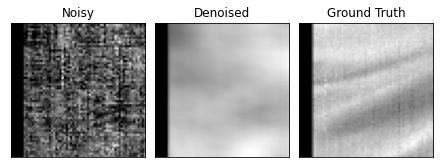

RMSE-NZ  Pred=0.0393  Noisy=0.1969 BEST
MAE-NZ   Pred=0.0292  Noisy=0.1941 BEST
PSNR     Pred=17.2 dB Noisy=3.2 dB BEST
Accuracy Pred=0.27    Noisy=0.00 BEST
SSM      Pred=0.90    Noisy=0.14
HOG MSE  Pred=0.04    Noisy=0.24
******************************************************
Index:10
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0353_09_00_15_noisy_idx006.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0353_09_00_15_nitid_idx008.tif


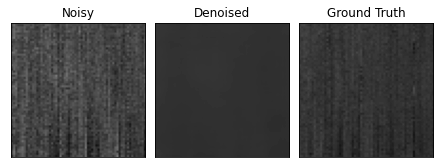

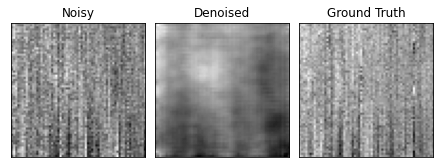

RMSE-NZ  Pred=0.0284  Noisy=0.0925 BEST
MAE-NZ   Pred=0.0224  Noisy=0.0774 BEST
PSNR     Pred=20.4 dB Noisy=10.1 dB BEST
Accuracy Pred=0.27    Noisy=0.06 BEST
SSM      Pred=0.62    Noisy=0.30
HOG MSE  Pred=0.06    Noisy=0.03
******************************************************
Index:11
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0357_01_00_5_noisy_idx006.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0357_01_00_5_nitid_idx008.tif


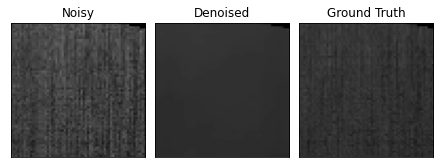

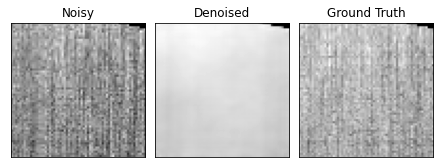

RMSE-NZ  Pred=0.0240  Noisy=0.0770 BEST
MAE-NZ   Pred=0.0191  Noisy=0.0644 BEST
PSNR     Pred=21.4 dB Noisy=11.2 dB BEST
Accuracy Pred=0.32    Noisy=0.08 BEST
SSM      Pred=0.69    Noisy=0.36
HOG MSE  Pred=0.10    Noisy=0.03
******************************************************
Index:12
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0357_01_01_7_noisy_idx020.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0357_01_01_7_nitid_idx017.tif


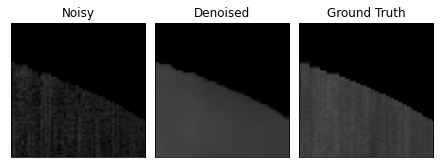

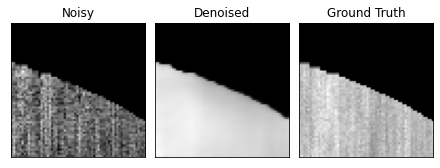

RMSE-NZ  Pred=0.0235  Noisy=0.1235 BEST
MAE-NZ   Pred=0.0118  Noisy=0.1063 BEST
PSNR     Pred=22.6 dB Noisy=8.2 dB BEST
Accuracy Pred=0.64    Noisy=0.19 BEST
SSM      Pred=0.86    Noisy=0.66
HOG MSE  Pred=0.06    Noisy=0.01
******************************************************
Index:13
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0618_03_01_9_noisy_idx020.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0618_03_01_9_nitid_idx017.tif


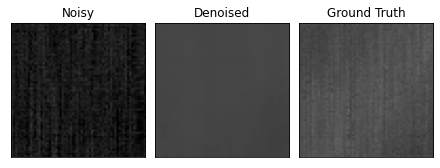

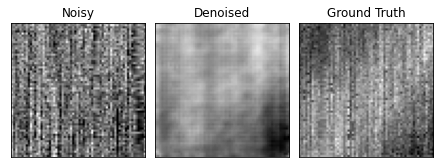

RMSE-NZ  Pred=0.0456  Noisy=0.2174 BEST
MAE-NZ   Pred=0.0392  Noisy=0.2121 BEST
PSNR     Pred=18.8 dB Noisy=5.2 dB BEST
Accuracy Pred=0.12    Noisy=0.00 BEST
SSM      Pred=0.70    Noisy=0.27
HOG MSE  Pred=0.06    Noisy=0.05
******************************************************
Index:14
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0720_00_04_11_noisy_idx157.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0720_00_04_11_nitid_idx146.tif


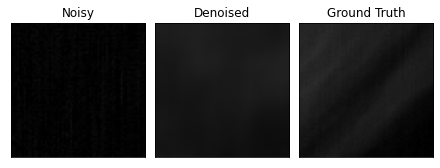

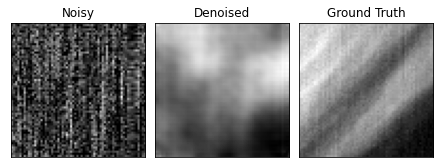

RMSE-NZ  Pred=0.0315  Noisy=0.0873 BEST
MAE-NZ   Pred=0.0255  Noisy=0.0780 BEST
PSNR     Pred=15.0 dB Noisy=6.2 dB BEST
Accuracy Pred=0.24    Noisy=0.06 BEST
SSM      Pred=0.80    Noisy=0.27
HOG MSE  Pred=0.09    Noisy=0.17
******************************************************
Index:15
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0720_01_00_2_noisy_idx006.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0720_01_00_2_nitid_idx008.tif


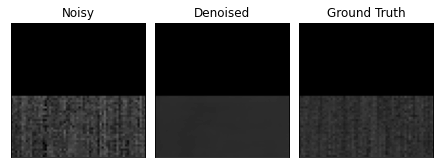

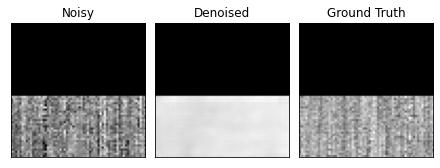

RMSE-NZ  Pred=0.0239  Noisy=0.0789 BEST
MAE-NZ   Pred=0.0131  Noisy=0.0631 BEST
PSNR     Pred=21.6 dB Noisy=11.2 dB BEST
Accuracy Pred=0.64    Noisy=0.09 BEST
SSM      Pred=0.79    Noisy=0.66
HOG MSE  Pred=0.20    Noisy=0.02
******************************************************
Index:16
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0726_03_01_15_noisy_idx020.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0726_03_01_15_nitid_idx017.tif


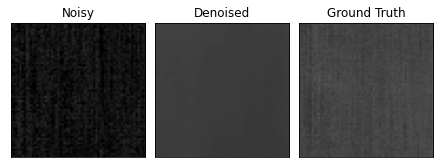

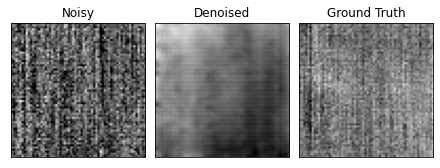

RMSE-NZ  Pred=0.0402  Noisy=0.2053 BEST
MAE-NZ   Pred=0.0350  Noisy=0.2012 BEST
PSNR     Pred=18.9 dB Noisy=4.7 dB BEST
Accuracy Pred=0.11    Noisy=0.00 BEST
SSM      Pred=0.74    Noisy=0.25
HOG MSE  Pred=0.07    Noisy=0.05
******************************************************


In [12]:
test_noisy_files, test_nitid_files, test_noisy, test_nitid = \
    dsutils.readDataset( IMG_PATH_TEST, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)

test_noisy, test_nitid = \
    dsutils.reshapeDataset( test_noisy, test_nitid,  hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )

test_indexes = np.arange(0,test_noisy.shape[0])

reports.predictByIndexes( model, test_noisy, test_nitid, test_noisy_files, test_nitid_files, test_indexes, ACCURACY_THRESHOLD )